TASK 1: Reviews

Group 2:
- correct implementation and working result
- nice visualization of the output
- a bit slow since you make a pause for the visuals

Group 10:
- concise and neat code
- correct implementation and working result
- is there a functional difference between decaying every episode vs. every step?

# GridWorld from homework01

In [1]:
import numpy as np

# inspired by: https://github.com/MJeremy2017/reinforcement-learning-implementation/blob/master/GridWorld/gridWorld.py
BOARD_ROWS = 3
BOARD_COLS = 5
# states = 3x5
WIN_STATE = (0, 2)
LOSE_STATE_I = (1, 0)
LOSE_STATE_II = (1, 4)
START = (2, 2)
WALL = (1, 2)
DETERMINISTIC = True

class GridWorld(): 
    def __init__(self, state=START):
        # Initialize GridWorld board
        self.board = np.zeros([BOARD_ROWS, BOARD_COLS])

        self.state = state
        self.det = DETERMINISTIC
        
    def giveReward(self):
        if self.state == WIN_STATE:
            return 1
        elif (self.state == LOSE_STATE_I) or (self.state == LOSE_STATE_II):
            return -1
        else:
            return 0

    def nextPosition(self, action):
        """
        action: up, down, left, right
        return: next position
        """
        if self.det:
            if action == 0:
                nextState = (self.state[0] - 1, self.state[1])
            elif action == 1:
                nextState = (self.state[0] + 1, self.state[1])
            elif action == 2:
                nextState = (self.state[0], self.state[1] - 1)
            else: 
                nextState = (self.state[0], self.state[1] + 1)
            # if next state legal aka. if field is free
            if (nextState[0] >= 0) and (nextState[0] <= (BOARD_ROWS -1)):  
                if (nextState[1] >= 0) and (nextState[1] <= (BOARD_COLS -1)):
                    if nextState != WALL:
                        return nextState
            return self.state
        
    def check_legal(self, action):
        nextState = self.nextPosition(action)
        # if next state legal aka. if field is free
        if (nextState[0] >= 0) and (nextState[0] <= (BOARD_ROWS -1)):  
            if (nextState[1] >= 0) and (nextState[1] <= (BOARD_COLS -1)):
                if nextState != WALL:
                    return True
        return False

    def showBoard(self):
        """Show the GridWorld playfield in ASCII art"""
        self.board[self.state] = 1
        # Wall / barrier
        self.board[WALL] = -1
        # Win / Lose states
        self.board[WIN_STATE] = 2
        self.board[LOSE_STATE_I] = -2
        self.board[LOSE_STATE_II] = -2
        for i in range(0, BOARD_ROWS):
            print('-----------------')
            out = '| '
            for j in range(0, BOARD_COLS):
                # Player
                if self.board[i, j] == 1:
                    token = '*'
                # Wall / barrier
                if self.board[i, j] == -1:
                    token = 'z'
                # Free fields
                if self.board[i, j] == 0:
                    token = '0'
                # Win state
                if self.board[i, j] == 2:
                    token = 'W'
                # Lose state
                if self.board[i, j] == -2:
                    token = 'L'
                out += token + ' | '
            print(out)
        print('-----------------')

GW = GridWorld()

In [2]:
class MC_Agent():
    def __init__(self):
        self.GW = GridWorld()
        self.end = False

        # Initialize epsilon and epsilon-decay
        self.epsilon = 1
        self.decay = 0.999

        # Initialize dictionary to safe returns
        self.returns = {}
        for i in range(BOARD_ROWS):
            for j in range(BOARD_COLS):
                for k in range(4):
                    self.returns[(i, j), k] = [0,0] 

        # Initialize q-value table
        self.q_values = np.random.uniform(size=(3,5,4))
    
    def policy(self, epsilon, state):
        # Epsilon-greedy policy to coose action
        legal = False
        while not legal:
            if np.random.rand() > epsilon:
                action = np.argmax(self.q_values[state])
            else:
                action = np.random.randint(0,4)
            legal = self.GW.check_legal(action)
        return action

    def makeAct(self):
        # Choose action
        self.action = self.policy(self.epsilon, self.GW.state)

        # Make action
        self.GW.state = self.GW.nextPosition(self.action)
        self.reward = self.GW.giveReward()
        if self.reward==1 or self.reward==-1:
            # End game
            self.end = True
    
    def reset(self):
        self.GW = GridWorld()
        self.end = False
    

    def play(self):
        i = 0
        # Create empty list to safe state of agent and action taken
        self.state_action_list = []

        while self.end==False:
            # Safe state before the action is taken
            last_state = self.GW.state
            self.makeAct()

            # Pair state and action
            self.state_action_list.append((last_state, self.action))
            # Decay epsilon after every turn
            self.epsilon *= self.decay

            i += 1
            # safety mechanism to prevent endless loop
            if i > 10000:
                self.reward = -1
                break

        # Remove duplicates from list of states and actions
        self.state_ation_list = list(dict.fromkeys(self.state_action_list))

        # Add reward for this episode to returns and safe turns
        for s,a in reversed(self.state_action_list):
            self.returns[s, a][0] += self.reward
            self.returns[s, a][1] += 1
        
        for s,a in self.returns:
            try:
                # Update q-values
                self.q_values[s[0],s[1],a] = round(self.returns[s,a][0]/self.returns[s,a][1],3)
            except:
                # Prevent division by 0
                self.q_values[s[0],s[1],a] = 0

        self.reset()
        return self.q_values[2,2,3]


In [3]:
class SARSA_Agent():
    def __init__(self):
        self.GW = GridWorld()
        self.end = False

        # Initialize epsilon and epsilon-decay
        self.epsilon = 1
        self.decay = 0.999

        # Initialize dictionary to safe returns
        self.returns = {}
        for i in range(BOARD_ROWS):
            for j in range(BOARD_COLS):
                for k in range(4):
                    self.returns[(i, j), k] = [0,0] 

        # Initialize q-value table
        self.q_values = np.random.uniform(size=(3,5,4))
    
    def policy(self, epsilon, state):
        # Epsilon-greedy policy to coose action
        legal = False
        while not legal:
            if np.random.rand() > epsilon:
                action = np.argmax(self.q_values[state])
            else:
                action = np.random.randint(0,4)
            legal = self.GW.check_legal(action)
        return action

    def makeAct(self):
        # Choose action
        self.action = self.policy(self.epsilon, self.GW.state)

        # Make action
        self.GW.state = self.GW.nextPosition(self.action)
        self.reward = self.GW.giveReward()
        if self.reward==1 or self.reward==-1:
            # End game
            self.end = True
    
    def reset(self):
        self.GW = GridWorld()
        self.end = False
        
    def SARSA_One(Q_old, r, Q_old_dash):
        alpha = 0.2 # what value should alpha take?
        gamma = 0.9
        Q_new = Q_old + alpha * (r + gamma * Q_old_dash - Q_old)
        return Q_new

    def play(self):
        i = 0
        # Create empty list to safe state of agent and action taken
        self.state_action_list = []

        while self.end==False:
            # Safe state before the action is taken
            last_state = self.GW.state
            self.makeAct()

            # Pair state and action 
            # EDIT: and new state
            self.state_action_list.append((last_state, self.action, self.reward, self.GW.state))
            new_action = self.policy(self.epsilon, self.GW.state)
            
            # update q-values
            q_old = self.q_values[last_state[0],last_state[1],self.action]
            q_old_dash = self.q_values[self.GW.state[0], self.GW.state[1], new_action]
            r = self.reward
            alpha = 0.2
            gamma = 0.9
            
            self.q_values[last_state[0],last_state[1],self.action] = q_old + alpha * (r + gamma * q_old_dash - q_old)
            
            # Decay epsilon after every turn
            self.epsilon *= self.decay

            i += 1
            # safety mechanism to prevent endless loop
            if i > 100:
                self.reward = -1
                break

        self.reset()
        
        # return q_values for the start state for task 3
        return self.q_values[2,2,3]


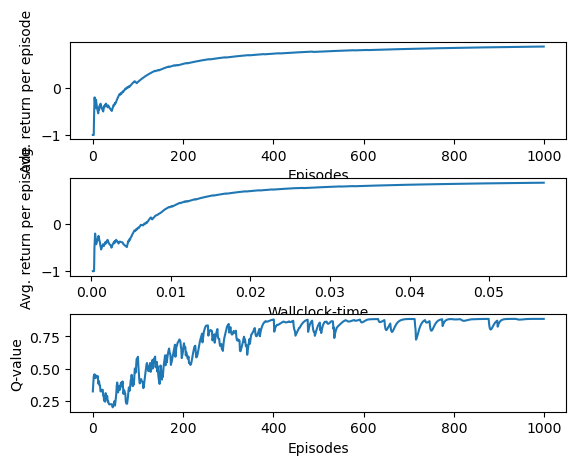

In [4]:
# loop for SARSA estimate 

import time
import matplotlib.pyplot as plt

ag = SARSA_Agent()

# Returns per episode
results = []
# Avg. returns per episode
rpe = []
# wallclock
times = []
start_time = time.time()

# task 3
start_q_values = []

episodes = 1000

for k in range(episodes):
    start_q_value = ag.play()
    start_q_values.append(start_q_value)
    results.append(ag.reward)
    rpe.append(np.mean(results))
    times.append(time.time()-start_time)

    

%matplotlib inline

plt.subplot(3,1,1)
plt.plot(np.arange(episodes), rpe);
plt.xlabel('Episodes');
plt.ylabel('Avg. return per episode');
plt.subplot(3,1,2)
plt.plot(times, rpe);
plt.xlabel('Wallclock-time');
plt.ylabel('Avg. return per episode');
plt.subplots_adjust(hspace=0.4)

plt.subplot(3,1,3)
plt.plot(start_q_values);
plt.xlabel('Episodes');
plt.ylabel('Q-value');

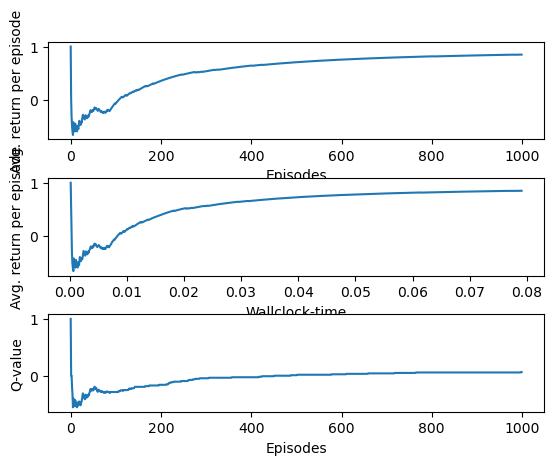

In [5]:
# loop for Monte Carlo estimate

import time
import matplotlib.pyplot as plt

ag = MC_Agent()


# Returns per episode
results = []
# Avg. returns per episode
rpe = []
# wallclock
times = []
start_time = time.time()

# task 3
start_q_values = []

episodes = 1000

for k in range(episodes):
    start_q_value = ag.play()
    start_q_values.append(start_q_value)
    #ag.play()
    results.append(ag.reward)
    rpe.append(np.mean(results))
    times.append(time.time()-start_time)

    

%matplotlib inline

plt.subplot(3,1,1)
plt.plot(np.arange(episodes), rpe);
plt.xlabel('Episodes');
plt.ylabel('Avg. return per episode');
plt.subplot(3,1,2)
plt.plot(times, rpe);
plt.xlabel('Wallclock-time');
plt.ylabel('Avg. return per episode');
plt.subplots_adjust(hspace=0.4)

plt.subplot(3,1,3)
plt.plot(start_q_values);
plt.xlabel('Episodes');
plt.ylabel('Q-value');

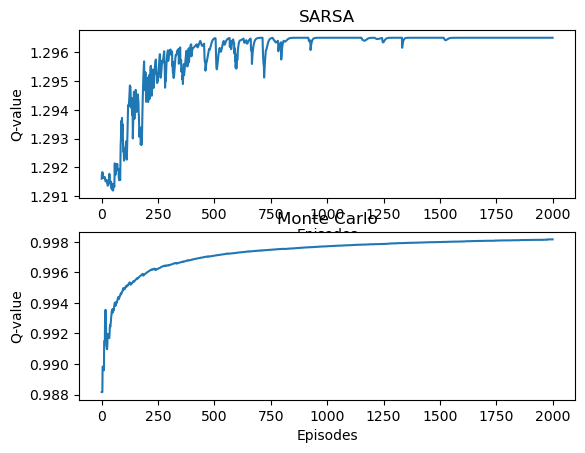

In [21]:
# loop for task 3
# the Q-value shown here is the start space with choosing action 4 (going right)
# I run the normal learning algorithm, so not only updating specifically this one Q-value
# I'm not even sure how I should only update one value in MC? Calculate all updates but only apllying one? Why?

import time
import matplotlib.pyplot as plt

agent_SARSA = SARSA_Agent()
agent_MC = MC_Agent()

q_values_total_SARSA = []
q_values_total_MC = []

runs = 200

for i in range(runs):
    
    episodes = 2000
    
    q_values_per_episode_SARSA = []
    q_values_per_episode_MC = []

    for k in range(episodes):
        q_value_SARSA = agent_SARSA.play()
        q_value_MC = agent_MC.play()
        q_values_per_episode_SARSA.append(q_value_SARSA)
        q_values_per_episode_MC.append(q_value_MC)
        
    q_values_total_SARSA.append(q_values_per_episode_SARSA)
    q_values_total_MC.append(q_values_per_episode_MC)

    
data_SARSA = np.array(q_values_total_SARSA)
data_MC = np.array(q_values_total_MC)

average_q_values_per_episode_SARSA = np.average(data_SARSA, axis=0)
average_q_values_per_episode_MC = np.average(data_MC, axis=0)
%matplotlib inline

plt.subplot(2,1,1)
plt.plot(average_q_values_per_episode_SARSA);
plt.xlabel('Episodes');
plt.ylabel('Q-value');
plt.title('SARSA');

plt.subplot(2,1,2)
plt.plot(average_q_values_per_episode_MC);
plt.xlabel('Episodes');
plt.ylabel('Q-value');
plt.title('Monte Carlo');

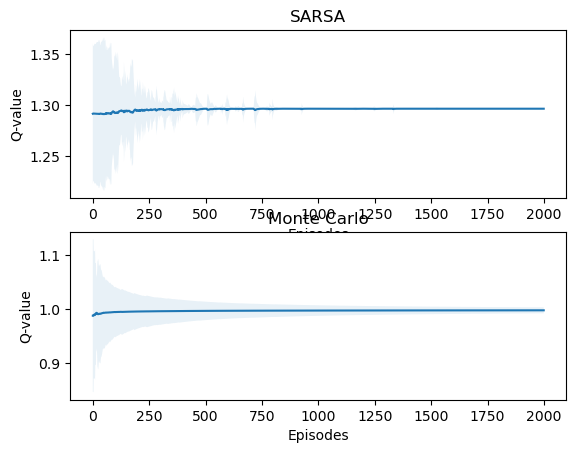

In [34]:
# plotting the results of task 3 with standard deviation
std_SARSA = np.std(data_SARSA, axis=0)
std_MC = np.std(data_MC, axis=0)

%matplotlib inline

plt.subplot(2,1,1)
plt.plot(average_q_values_per_episode_SARSA);
plt.fill_between(range(len(average_q_values_per_episode_SARSA)), average_q_values_per_episode_SARSA - std_SARSA, average_q_values_per_episode_SARSA + std_SARSA, alpha=.1)
plt.xlabel('Episodes');
plt.ylabel('Q-value');
plt.title('SARSA');

plt.subplot(2,1,2)
plt.plot(average_q_values_per_episode_MC);
plt.fill_between(range(len(average_q_values_per_episode_MC)), average_q_values_per_episode_MC - std_MC, average_q_values_per_episode_MC + std_MC, alpha=.1)
plt.xlabel('Episodes');
plt.ylabel('Q-value');
plt.title('Monte Carlo');

INTERPRETATION

Monte Carlo shows a greater variance at the beginning (std values have a bigger range) but the variance also shrinks faster than with SARSA

Where these values are has a lot to do with the initial random value

# Updating only the starting Q-value

In [40]:
class SARSA_Agent_Task3():
    def __init__(self):
        self.GW = GridWorld()
        self.end = False

        # Initialize epsilon and epsilon-decay
        self.epsilon = 1
        self.decay = 0.999

        # Initialize dictionary to safe returns
        self.returns = {}
        for i in range(BOARD_ROWS):
            for j in range(BOARD_COLS):
                for k in range(4):
                    self.returns[(i, j), k] = [0,0] 

        # Initialize q-value table
        self.q_values = np.random.uniform(size=(3,5,4))
    
    def policy(self, epsilon, state):
        # Epsilon-greedy policy to coose action
        legal = False
        while not legal:
            if np.random.rand() > epsilon:
                action = np.argmax(self.q_values[state])
            else:
                action = np.random.randint(0,4)
            legal = self.GW.check_legal(action)
        return action

    def makeAct(self):
        # Choose action
        self.action = self.policy(self.epsilon, self.GW.state)

        # Make action
        self.GW.state = self.GW.nextPosition(self.action)
        self.reward = self.GW.giveReward()
        if self.reward==1 or self.reward==-1:
            # End game
            self.end = True
    
    def reset(self):
        self.GW = GridWorld()
        self.end = False
        
    def SARSA_One(Q_old, r, Q_old_dash):
        alpha = 0.2 # what value should alpha take?
        gamma = 0.9
        Q_new = Q_old + alpha * (r + gamma * Q_old_dash - Q_old)
        return Q_new

    def play(self):
        i = 0
        # Create empty list to safe state of agent and action taken
        self.state_action_list = []

        while self.end==False:
            # Safe state before the action is taken
            last_state = self.GW.state
            self.makeAct()

            # Pair state and action 
            # EDIT: and new state
            self.state_action_list.append((last_state, self.action, self.reward, self.GW.state))
            new_action = self.policy(self.epsilon, self.GW.state)
            
            # update q-values
            q_old = self.q_values[last_state[0],last_state[1],self.action]
            q_old_dash = self.q_values[self.GW.state[0], self.GW.state[1], new_action]
            r = self.reward
            alpha = 0.2
            gamma = 0.9
            
            #only updating the first value
            if (last_state[0] == 2 and last_state[1]==2 and self.action==3):
                self.q_values[last_state[0],last_state[1],self.action] = q_old + alpha * (r + gamma * q_old_dash - q_old)
            
            # Decay epsilon after every turn
            self.epsilon *= self.decay

            i += 1
            # safety mechanism to prevent endless loop
            if i > 100:
                self.reward = -1
                break

        self.reset()
        
        # return q_values for the start state for task 3
        return self.q_values[2,2,3]

In [41]:
class MC_Agent_Task3():
    def __init__(self):
        self.GW = GridWorld()
        self.end = False

        # Initialize epsilon and epsilon-decay
        self.epsilon = 1
        self.decay = 0.999

        # Initialize dictionary to safe returns
        self.returns = {}
        for i in range(BOARD_ROWS):
            for j in range(BOARD_COLS):
                for k in range(4):
                    self.returns[(i, j), k] = [0,0] 

        # Initialize q-value table
        self.q_values = np.random.uniform(size=(3,5,4))
    
    def policy(self, epsilon, state):
        # Epsilon-greedy policy to coose action
        legal = False
        while not legal:
            if np.random.rand() > epsilon:
                action = np.argmax(self.q_values[state])
            else:
                action = np.random.randint(0,4)
            legal = self.GW.check_legal(action)
        return action

    def makeAct(self):
        # Choose action
        self.action = self.policy(self.epsilon, self.GW.state)

        # Make action
        self.GW.state = self.GW.nextPosition(self.action)
        self.reward = self.GW.giveReward()
        if self.reward==1 or self.reward==-1:
            # End game
            self.end = True
    
    def reset(self):
        self.GW = GridWorld()
        self.end = False
    

    def play(self):
        i = 0
        # Create empty list to safe state of agent and action taken
        self.state_action_list = []

        while self.end==False:
            # Safe state before the action is taken
            last_state = self.GW.state
            self.makeAct()

            # Pair state and action
            self.state_action_list.append((last_state, self.action))
            # Decay epsilon after every turn
            self.epsilon *= self.decay

            i += 1
            # safety mechanism to prevent endless loop
            if i > 100:
                self.reward = -1
                break

        # Remove duplicates from list of states and actions
        self.state_ation_list = list(dict.fromkeys(self.state_action_list))

        # Add reward for this episode to returns and safe turns
        for s,a in reversed(self.state_action_list):
            self.returns[s, a][0] += self.reward
            self.returns[s, a][1] += 1
        
        # only updating one specific Q-value
        for s,a in self.returns:
            if s[0] == 2 and s[1] == 2 and a == 3:
                try:
                    # Update q-values
                    self.q_values[s[0],s[1],a] = round(self.returns[s,a][0]/self.returns[s,a][1],3)
                except:
                    # Prevent division by 0
                    self.q_values[s[0],s[1],a] = 0

        self.reset()
        return self.q_values[2,2,3]

In [42]:
# loop for task 3 with only updating that specific Q-value
# seems to go into an endless loop - so run on your own risk

import time
import matplotlib.pyplot as plt

agent_SARSA = SARSA_Agent_Task3()
agent_MC = MC_Agent_Task3()

q_values_total_SARSA = []
q_values_total_MC = []

runs = 200

for i in range(runs):
    
    episodes = 2000
    
    q_values_per_episode_SARSA = []
    q_values_per_episode_MC = []

    for k in range(episodes):
        q_value_SARSA = agent_SARSA.play()
        q_value_MC = agent_MC.play()
        q_values_per_episode_SARSA.append(q_value_SARSA)
        q_values_per_episode_MC.append(q_value_MC)
        
    q_values_total_SARSA.append(q_values_per_episode_SARSA)
    q_values_total_MC.append(q_values_per_episode_MC)

    
data_SARSA = np.array(q_values_total_SARSA)
data_MC = np.array(q_values_total_MC)

average_q_values_per_episode_SARSA = np.average(data_SARSA, axis=0)
average_q_values_per_episode_MC = np.average(data_MC, axis=0)
%matplotlib inline

plt.subplot(2,1,1)
plt.plot(average_q_values_per_episode_SARSA);
plt.xlabel('Episodes');
plt.ylabel('Q-value');
plt.title('SARSA');

plt.subplot(2,1,2)
plt.plot(average_q_values_per_episode_MC);
plt.xlabel('Episodes');
plt.ylabel('Q-value');
plt.title('Monte Carlo');

KeyboardInterrupt: 